In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
from typing import List
from collections import OrderedDict
import os
import pandas as pd
import numpy as np
from scipy.stats import gaussian_kde
import seaborn as sns
import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)

In [24]:
class Segmentations:
    def __init__(self,
                 path_to_seg_file: str,
                 song_names: List[str]):
        segment_mappings, self.segments, _ = \
            np.load(path_to_seg_file, allow_pickle=True)
        self.song_names = [name.upper() for name in song_names]
        self.segment_mappings = OrderedDict((v, k) for k, v in segment_mappings.items())
    
    def get_song_name_range(self, name):
        song_idx = self.song_names.index(name)
        if song_idx == -1:
            raise ValueError(f"Song {song} not found.")
        segment_idx = self.segment_mappings[song_idx]
        return list(range(segment_idx, segment_idx + len(self.segments[song_idx])))

In [25]:
musdb_root = "/exports/projects/computer-audition/data/musdb/raw/stems/"
train_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "train"))])
train_segmentations = Segmentations("train_segmentation.npy", train_songs)
test_songs = sorted([p.rsplit(".", 2)[0] for p in os.listdir(os.path.join(musdb_root, "test"))])
test_segmentations = Segmentations("test_segmentation.npy", test_songs)

test_data = {}
test_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented/aggreggate.csv")
test_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented/aggreggate.csv")
test_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented/aggreggate.csv")
test_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented/aggreggate.csv")
         
train_data = {}
train_data["OpenUnmix"] = pd.read_csv("results/OpenUnmix/MUSDB18Segmented_train/aggreggate.csv")
train_data["Demucs"] = pd.read_csv("results/Demucs/MUSDB18Segmented_train/aggreggate.csv")
train_data["ConvTasNet"] = pd.read_csv("results/ConvTasNet/MUSDB18Segmented_train/aggreggate.csv")
train_data["Wave-U-Net"] = pd.read_csv("results/Wave-U-Net/MUSDB18Segmented_train/aggreggate.csv")

genre_metadata = pd.concat([
    pd.read_csv("medleydb_genre.csv"), pd.read_csv("dsd_genre.csv", quotechar='"'), pd.read_csv("self_labeled.csv")
],axis=0).reset_index()[["Artist - Title", "Genre"]]
genre_metadata["Artist - Title"] = genre_metadata["Artist - Title"].apply(lambda name: name.replace(" Multitracks", "").upper())
genre_metadata["Split"] = genre_metadata["Artist - Title"].apply(
    lambda name: 'train' if name in train_segmentations.song_names
                         else ('test' if name in test_segmentations.song_names
                                      else None)
)
# Combining pop and rock together, because DSD combines them
genre_metadata["Genre"] = genre_metadata["Genre"].apply(lambda name: "Pop/Rock" if name in ["Pop", "Rock"] else name)
genre_metadata_valid = genre_metadata[(genre_metadata["Split"] == 'test') | (genre_metadata["Split"] == 'train')]

In [26]:
genres = genre_metadata_valid["Genre"].value_counts()
display(genres)

Pop/Rock             97
Singer/Songwriter    16
Heavy Metal          12
Electronic            9
Rap                   8
Jazz                  3
Musical Theatre       2
Reggae                2
Country               1
Name: Genre, dtype: int64

In [27]:
def split_by_sources(df):
    return {name: g_df for name, g_df in df.groupby(by="source")}
test_data_sources = {k: split_by_sources(df) for k, df in test_data.items()}
train_data_sources = {k: split_by_sources(df) for k, df in train_data.items()}

In [38]:
def display_genre_info(sources_data, genre, split):
    """
    Things this function should do:
     - Output SNR, SI-SDR, and SI-SAR for each source
     - Density plot of SI-SDR vs. MIX-SI-SDR
    """
    assert split in ["train", "test"]
    def _filter_files(song_df):
        # this might be slow...
        song_names = song_df["Artist - Title"]
        segmentation = train_segmentations if split == "train" else test_segmentations
        song_numbers = set(sum([
            segmentation.get_song_name_range(name)
            for name in song_names
        ], []))
        print(song_numbers)
        filtered_data = {}
        for source, df in sources_data.items():
            filtered_data[source] = df[df["file"].apply(
                lambda file: (int(file.split(".")[0]) in song_numbers)
            )]
        return filtered_data
    
    def _generate_aggregations(sources_data):
        agg = {}
        sources = list(sources_data.keys())
        for source in sources:
            for metric in ["SNR", "SI-SDR", "SI-SAR"]:
                mean = sources_data[source][metric].mean()
                agg[metric] = agg.get(metric, []) + [mean]
        return pd.DataFrame(agg, index=sources)
                
    
    def _generate_graphs(sources_data):
        fig, axes = plt.subplots(1, len(sources_data), figsize=(12, 3))
        for idx, (source, source_df) in enumerate(sources_data.items()):
            ax = axes[idx]
            ax.set_title(source)
            x = source_df["MIX-SI-SDR"]
            y = source_df["SI-SDR"]
            xy = np.vstack([x.to_numpy(), y.to_numpy()])
            z = gaussian_kde(xy)(xy)
            sns.scatterplot(x=x, y=y, hue=z*10, ax=ax, legend=False)
        return fig
    
    song_df = genre_metadata_valid[(genre_metadata_valid["Genre"] == genre)
                                   & (genre_metadata_valid["Split"] == split)]
    filtered_df = _filter_files(song_df)
    if len(list(filtered_df.values())[0].index) == 0:
        return
    display(_generate_aggregations(filtered_df))
    display(_generate_graphs(filtered_df))


# Test

OPENUNMIX
POP/ROCK
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 252, 253, 254, 255, 256, 257, 

,SNR,SI-SDR,SI-SAR
bass,5.168985,2.951297,3.943815
drums,6.090812,4.613090,5.151488
other,4.082261,1.669686,2.765086
vocals,6.199123,4.813917,5.455244


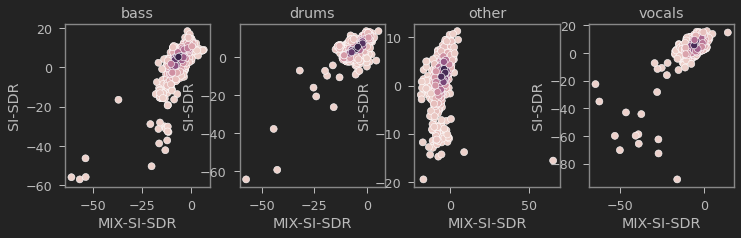

SINGER/SONGWRITER
{1536, 1537, 1538, 1539, 1540, 1541, 1542, 1543, 1544, 1523, 1524, 1525, 1526, 1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535}


,SNR,SI-SDR,SI-SAR
bass,4.503944,2.540967,5.485651
drums,11.641024,11.342516,11.653101
other,0.723243,-5.968477,-4.700091
vocals,6.960144,-0.150619,-0.015866


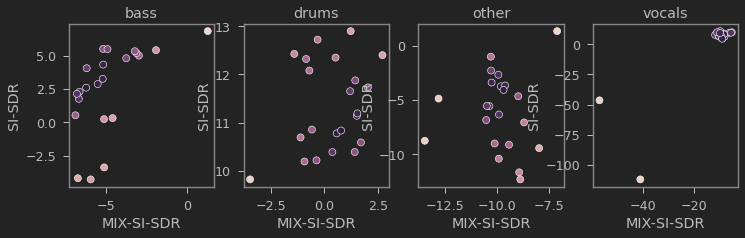

HEAVY METAL
{1585, 1586, 1587, 1588, 1589, 1590, 1591, 1592, 1593, 1594, 1595, 1596, 1597, 1598, 1599, 1600, 1601, 1602, 1603, 1604, 1605, 1606, 1607, 1608, 1609, 1610, 1611, 1612, 583, 584, 585, 586, 587, 588, 589, 590, 591, 592, 593, 594, 595, 596, 597, 598, 599, 600, 601, 602, 603, 604, 605, 606, 607, 608, 609, 610, 611, 612, 613, 614, 615, 616, 617, 618, 619, 620, 621, 622, 623, 624, 625, 626, 627, 628, 629, 630, 631, 1613, 1468, 1469, 1470, 1471, 1472, 1473, 1474, 1475, 1476, 1477, 1478, 1479, 1480, 1481, 1482, 1483, 1484, 1485, 1486, 1487, 1488, 1489, 1490, 1491, 1492, 1493, 1494, 1495, 1496, 1497, 1498, 1499, 1500, 1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515, 1516, 1517, 1518, 1519, 1520, 1521, 1522}


,SNR,SI-SDR,SI-SAR
bass,1.768165,-1.739464,-0.303581
drums,5.131354,3.260307,4.086056
other,5.857747,4.427926,6.018615
vocals,4.873553,1.431324,1.764827


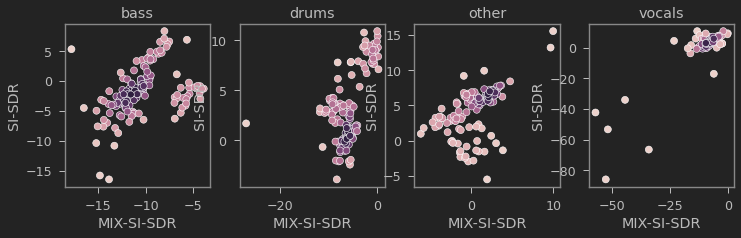

ELECTRONIC
{548, 549, 550, 551, 552, 553, 554, 555, 556, 557, 558, 559, 560, 561, 562, 563, 564, 565, 566, 567, 568, 569, 570, 571, 572, 573, 574, 575, 576, 577, 578, 579, 580, 581, 582, 1151, 1152, 1153, 1154, 1155, 1156, 1157, 1158, 1159, 1160, 1161, 1162, 1163, 1164, 1269, 1270, 1271, 1272, 1273, 1274, 1275, 1276, 1277, 1278, 1279, 1280, 1281, 1282, 1283, 1284, 1285, 1286, 1287, 1288, 1289, 1290, 1291, 1292, 918, 919, 920, 921, 922, 923, 924, 925, 926, 927, 928, 929, 930, 931, 932, 933, 934, 935, 936, 937, 938}


,SNR,SI-SDR,SI-SAR
bass,3.204771,0.299266,0.672535
drums,6.637079,5.543366,7.416020
other,1.304447,-6.265001,-4.698386
vocals,1.424797,-4.123877,-3.389241


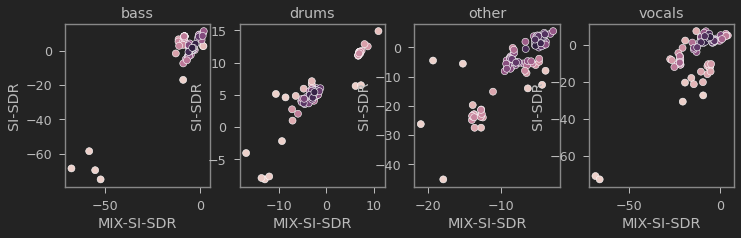

RAP
{1074, 1075, 1076, 1077, 1078, 1079, 1080, 1081, 1082, 1083, 1084, 1085, 1086, 1087, 1088, 1089, 1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099, 1100, 1101, 1102, 1103, 1104, 1105, 1106, 1107, 1108, 1109, 1110, 1111, 1112, 1113, 1114, 1115, 1116, 1117, 1118, 1119, 1120, 1121, 1122, 1123, 1124, 1125, 1126, 1127, 1128, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661, 662, 663, 664, 665, 666, 667, 668, 669, 670, 671, 672, 673, 674, 675, 676, 677, 678, 679, 680, 681, 682, 683, 684, 685, 686, 687, 688, 689, 690, 691, 692, 693, 694, 695, 696, 697, 698, 699, 700, 701, 702, 703, 704, 705, 706, 707, 708, 709, 710, 711, 756, 757, 758, 759, 760, 761, 762, 763, 764, 765, 766, 767, 768, 769, 770, 771, 772, 773, 774, 775, 776, 777, 778, 779, 780, 781, 782, 783, 784, 785, 786, 787, 788, 789, 790, 791, 792, 793, 794, 795, 796}


,SNR,SI-SDR,SI-SAR
bass,6.508823,5.347493,5.921120
drums,7.496616,6.450957,6.667402
other,2.560855,-0.560258,0.205841
vocals,8.277548,7.602518,8.299020


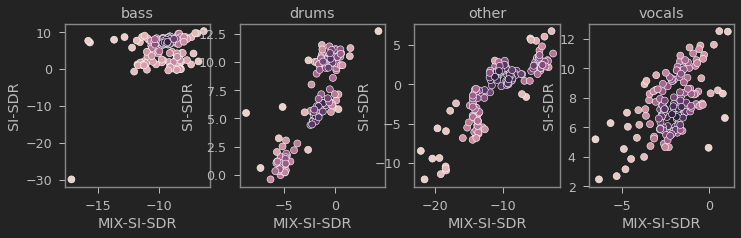

JAZZ
set()


,SNR,SI-SDR,SI-SAR
bass,NaN,NaN,NaN
drums,NaN,NaN,NaN
other,NaN,NaN,NaN
vocals,NaN,NaN,NaN


ValueError: `dataset` input should have multiple elements.

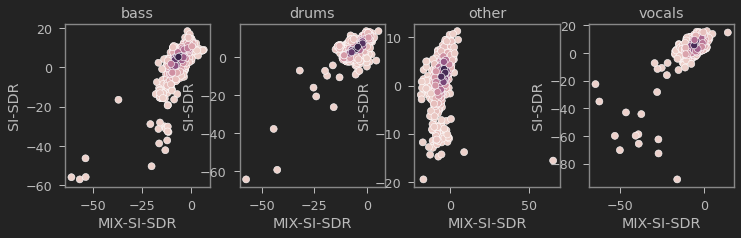

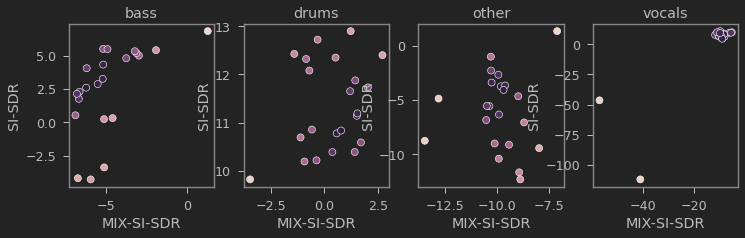

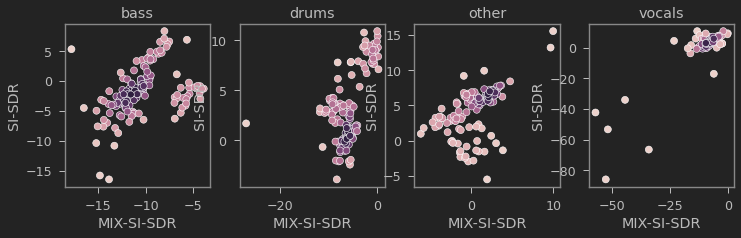

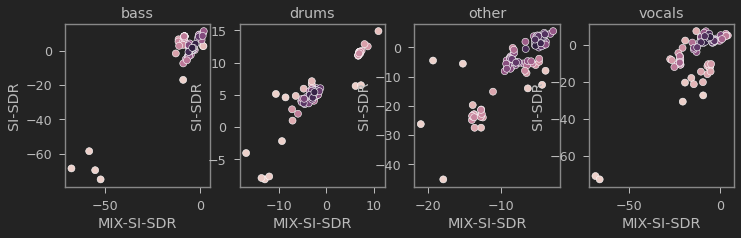

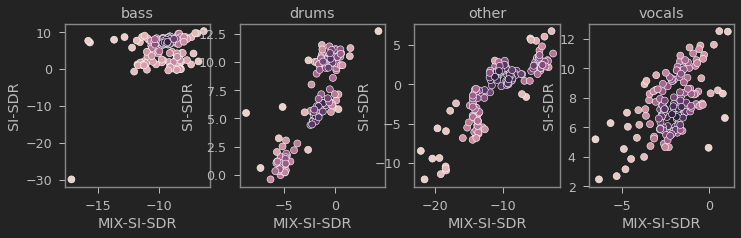

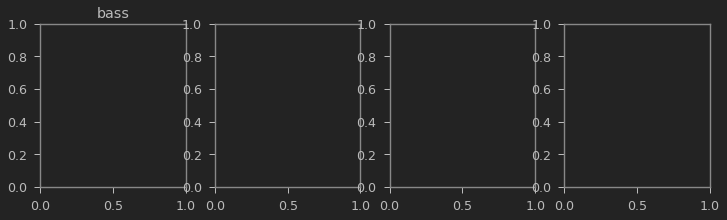

In [39]:
for key, sources_data in test_data_sources.items():
    print(key.upper())
    for genre in genres.index:
        print(genre.upper())
        display_genre_info(sources_data, genre, "test")

# Train

In [ ]:
for key, sources_data in test_data_sources.items():
    print(key.upper())
    for genre in genres.index:
        print(genre.upper())
        display_genre_info(sources_data, genre, "train")